<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span></span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit


In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
df = df.set_index('datetime')

In [7]:
df = df.sort_index()

In [8]:
df.index.is_monotonic

True

In [9]:
df = df.resample('1H').sum()

**Выводы:**
* столбец datetime приведен к типу даты и преобразован в индекс
* данные отсортированы и проверены на пропуски
* значения заказов промуммированы и отражены в пределах часа

## Анализ

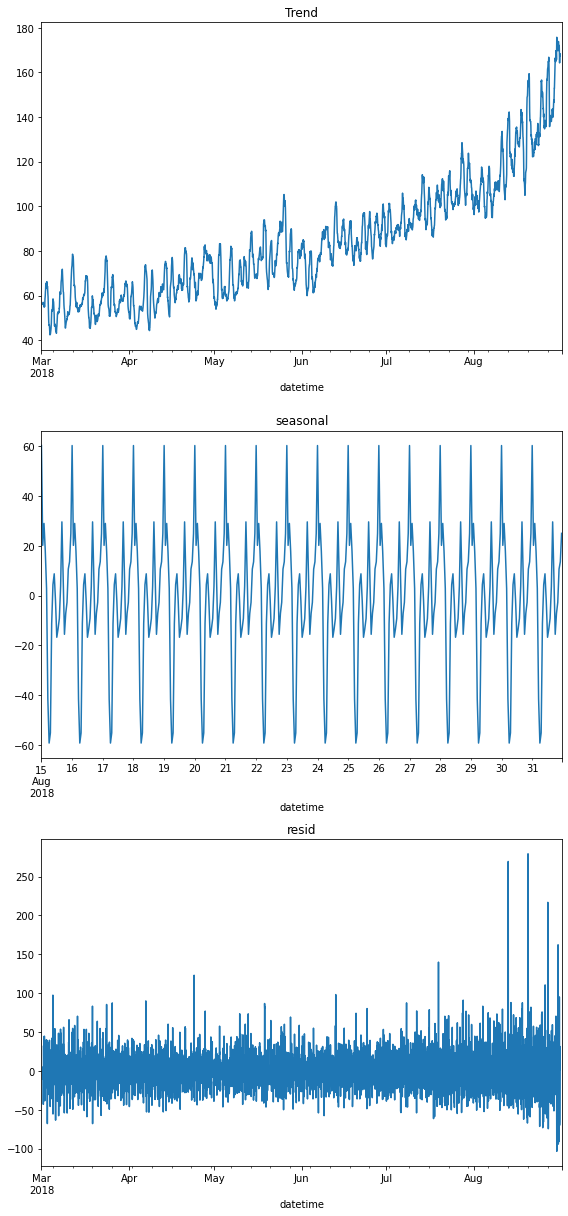

In [10]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(8,17))
plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-15':'2018-08-31'].plot()
plt.title('seasonal')
plt.subplot(313)
decomposed.resid.plot()
plt.title('resid')
plt.tight_layout()

Тренд показывает неуклонное увеличение с каждым месяцем. Сезонность неинформативная, так как данные за один неполный год.

In [11]:
def adding_features(df, max_lag, rolling_size):
    '''добавление признаков календарных, отстающих значений и скользящего среднего'''
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):   
        df['lag{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    return df

In [12]:
df_new = adding_features(df, 5, '7D')


In [13]:
df_new.dropna(inplace=True) #удалены пропуски, возникшие при применении скользящего среднего

In [14]:
df_new.head()

,num_orders,year,month,dayofweek,hour,lag1,lag2,lag3,lag4,lag5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 05:00:00,6,2018,3,3,5,43.0,66.0,71.0,85.0,124.0,77.800000
2018-03-01 06:00:00,12,2018,3,3,6,6.0,43.0,66.0,71.0,85.0,65.833333
2018-03-01 07:00:00,15,2018,3,3,7,12.0,6.0,43.0,66.0,71.0,58.142857
2018-03-01 08:00:00,34,2018,3,3,8,15.0,12.0,6.0,43.0,66.0,52.750000
2018-03-01 09:00:00,69,2018,3,3,9,34.0,15.0,12.0,6.0,43.0,50.666667


<AxesSubplot:xlabel='datetime'>

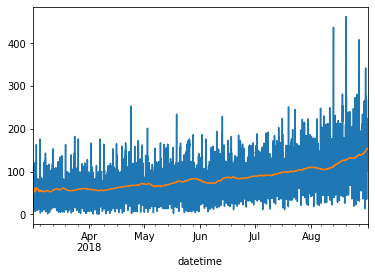

In [15]:
df_new['num_orders'].plot()
df_new['rolling_mean'].plot()


In [16]:
features = df_new.drop(['num_orders'], axis=1)
target = df_new['num_orders']

In [17]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, shuffle=False, test_size=0.2)

In [18]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, shuffle=False, test_size=0.5)

In [19]:
print('train:', features_train.index.min(), features_train.index.max())
print('valid:', features_valid.index.min(), features_valid.index.max())
print('test:', features_test.index.min(), features_test.index.max())

train: 2018-03-01 05:00:00 2018-07-26 04:00:00
valid: 2018-07-26 05:00:00 2018-08-13 13:00:00
test: 2018-08-13 14:00:00 2018-08-31 23:00:00


**Выводы:**
* тренд отражает постепенный рост 
* для сглаживания минимальных и максимальных значений применяется скользящее среднее с периодом 7 дней.
* целевой признак отделен
* данные поделены на обучающую, валидационную и тестовую выборки в соотношении 80:10:10

## Обучение

In [20]:
lr = LinearRegression()
lr.fit(features_train, target_train)
prediction = lr.predict(features_valid)
result_lr = mean_squared_error(prediction, target_valid) **0.5
print(result_lr)

40.42689384611972


Линейная регрессия сходу показала неплохой результат

In [25]:
%%time
model = CatBoostRegressor(loss_function='RMSE')
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {'max_depth' : [0, 10, 15], 
              'n_estimators' : [150,500]}
cat_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv)
cat_model.fit(features_train, target_train, verbose=False)
prediction = cat_model.predict(features_valid)
result_cb = mean_squared_error(prediction, target_valid) **0.5
print(result_cb)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

32.15517591471562
CPU times: user 25min 36s, sys: 14min 51s, total: 40min 27s
Wall time: 41min 43s


In [26]:
cat_model.best_params_

{'max_depth': 10, 'n_estimators': 500}

Модель CatBoost с подбором параметров показывает хороший результат, но времени на обучение требует много.

In [27]:
%%time
modelLight = LGBMRegressor(random_state = 12345)
param_grid = {'max_depth' : [0, 10, 15], 
              'n_estimators' : [150,500]}
model_lgbm = GridSearchCV(estimator=modelLight, param_grid=param_grid, cv=tscv)
model_lgbm.fit(features_train, target_train)
prediction = model_lgbm.predict(features_valid)
result_lgbm = mean_squared_error(prediction, target_valid) **0.5
print(result_lgbm)


31.658553242800807
CPU times: user 1h 50min 7s, sys: 1min 6s, total: 1h 51min 13s
Wall time: 1h 51min 54s


In [28]:
model_lgbm.best_params_

{'max_depth': 0, 'n_estimators': 150}

Данная модель имеет самый лучший результат.

In [69]:
r = pd.DataFrame([['catboost', result_cb, '41min 43s'],
                 ['LigthGBM', result_lgbm, '1h 51min'],
                 ['LinearRegression', result_lr, '-'],
                 ], 
                columns=['model', 'RMSE', 'time to learn'])
display(r)

,model,RMSE,time to learn
0,catboost,32.155176,41min 43s
1,LigthGBM,31.658553,1h 51min
2,LinearRegression,50.021109,-


## Тестирование

In [38]:
features_concat = pd.concat([features_train, features_valid], axis=0)
features_concat.sort_index(inplace=True)
target_concat = pd.concat([target_train, target_valid], axis=0)
target_concat.sort_index(inplace=True)


In [39]:
lgbm_model = LGBMRegressor(random_state = 12345, max_depth=0, n_estimators=150).fit(features_concat, target_concat)
target_test['lgbm_prediction'] = lgbm_model.predict(features_test)
lgbm_result = mean_squared_error(target_test['lgbm_prediction'], target_test) **0.5
print(lgbm_result)

42.418463727219255


Подходящий по качеству вариант, но времени на обучение трубует много

In [47]:
cat_model = CatBoostRegressor(max_depth=10, n_estimators=500, loss_function='RMSE', verbose=False)
cat_model.fit(features_concat, target_concat)
cat_prediction = cat_model.predict(features_test)
cat_result = mean_squared_error(cat_prediction, target_test) **0.5
print(cat_result)

48.81219192647887


In [49]:
lr = LinearRegression()
lr.fit(features_concat, target_concat)
lr_prediction = lr.predict(features_test)
result_lr = mean_squared_error(lr_prediction, target_test) **0.5

In [50]:
print(mean_squared_error(target_test, lr.predict(features_test))**0.5)

50.02110904933349


In [61]:
lgbm_prediction = pd.DataFrame(lgbm_prediction, index=target_test.index)

In [63]:
cat_prediction = pd.DataFrame(cat_prediction, index=target_test.index)

In [64]:
lr_prediction = pd.DataFrame(lr_prediction, index=target_test.index)

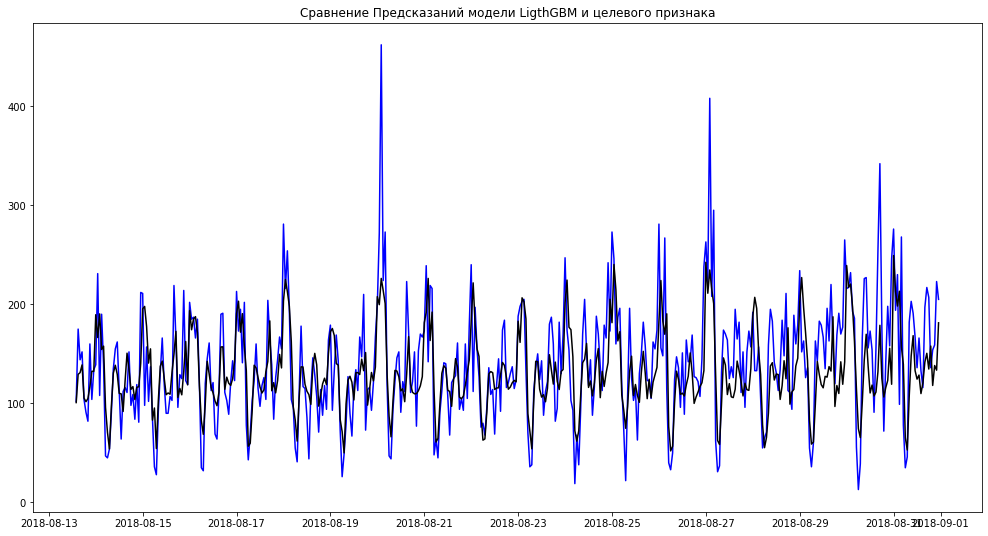

In [72]:
plt.figure(figsize=(17, 9))
plt.title('Сравнение Предсказаний модели LigthGBM и целевого признака')
plt.plot(target_test, label='target_test', color='blue')
plt.plot(lgbm_prediction, label='prediction', color='black')


**Выводы:**
* данные обработаны (приведены к нужному типу, отсортированы и проверены на хронологичность)
* изменен интервал временного ряда в пределах часа
* тренд данных отражает постепенный рост
* рассчитано скользящее среднее с периодом 7 дней.
* данные поделены на обучающую, валидационную и тестовую выборки в соотношении 80:10:10
* обучены несколько моделей. Лучший результат у модели LigthGBM - 31.658553
* объединены обучающие и валидационные данные 
* проведено переобучение моделей на объединенных данные
* лучший по качеству предсказаний является также модель LigthGBM - 42.418. Но врмени на обучение ей требуется достаточно много.
* построен график для сравнения предсказанных показателей модели LigthGBM и целевого признака